# Pairs Trading Strategy Design & Backtest

The definition of Pairs Trading is to take advantage of the mispricing between two or more assets by taking long and short portfolio, betting the related movement will converge back when mispricing situation happening. The principle is buy undervalued and sell overvalued. This is a very charming strategy that we can extend the idea in any market of interest. 

The first pairs trading bears its roots in equity market, but we can possibly extend the idea into commodities, cryptos, and even options market.

### Import required lib

In [143]:
import warnings
import numpy as np
import pandas as pd
import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.api import adfuller
import matplotlib.pyplot as plt
import pyfolio as pf
import yfinance as yf
from scipy import optimize
warnings.filterwarnings("ignore")

The numerical techniques are regression computation in matrix form, Engle-Granger procedure, and statistical tests.

A) multivariate cointegration (Johansen Procedure)


B) robustness checking of cointegration weights, ie, by adaptive estimation of your regression parameters with statistical filters.

## Signal Generation and Backtesting
- Be inventive beyond equity pairs: consider commodity futures, instruments on interest rates, and aggregated indices. (Initially consider to find the candidate pairs from crude oil)
- Arb is relized by using cointegrating coff as allocation w. all project designs should including trading signal generation(OU process fitting) and backtesting.
- does P&L behave as expected for cointegration arb trade? Is P&L coming from a few or many trades, what is half-life? Maximum Drawdown and behaviour of volatility/VaR?
- Introduce liquidity and algorithmic flow considerations (a model of order flow). Any rules on accumulating the position? What impact bid-ask spread and transaction costs will make?
## Step-by-step instructions
- multivariate cointegration to identify cases
- Part I: pairs trading design
    - 1. re-code regression estimation in martrix form - your own OLS implementation which you can re-use. Regression between stationary variables(DF test regression/difference equation) has optional model specification test for (a)identifying optimal lag p with AIC BIC tests and (b) stability check
    - 2. Implement Engle-Granger procedure for each pair. Step1 use ADF test for unit root with lag1. Step2, formulate both correction equation and decide which one is more important
    - 3. Decide signals: $\mu_e +- Z\sigma_{eq}$ and exit on $\mu_t$
    - 4. At first aussme Z=1. Then change Z sightly upwards and downwards - compute P&L for each case of bounds. Alternatively run an optimization that varies Z and maxmize the P&L or other criterion.
    - 5. Optionally us VECM in order select the best candidate for pairs trading (or basket trading).
    
- Part II: Backtesting
    - 1. perform systematic backtesting of your trading strategy platform o produce drawdown plots, rolling Sharpe ratio and rolling beta
    - 2. keep delivering staionary spread over 3-6 months. Kalman filter will give updated beta. However, you can simply re-estmate cointergration by shifting data 1-2 weeks and report beta and EG.
    - 3. use time series CV
    
    
Time Series Project Workshop, Cointegration Lecture and Pairs Trading tutorial are your key resources.

# Part I: Pairs Trading Design
## Data Processing
One study by Jacob & Weber conducted several international markets which has empirically proven that the pairs trading works the most in emerging market, either from the high ineffciencies or a large number of available pairs. So I believe some innovative market has more opportunities than equity market.

In this case, I want to study model-driven statistical arbitrage strategies in U.S. equities, commodities and crypto market. The crpyto is the youngest and has less research than other assets, which becomes very attractive for pairs trading strategy design. From those three different perspectives, we can identify multiple strategy implementations and more profitable opportunities. So, in the first step, we sort out a list of available symbols and prepare them for filtering.

In [125]:
## In this case, I want to implement pairs trading from two perspectives - equity and commodity market.
## First I listed some potentially profitable tickers to be tested from different market.
start = '2005-01-01'
end = '2022-07-30'
tickers_commodity = {'Gold':'GC=F',
                     'Sliver':'SI=F',
                     'Crude Oil':'CL=F',
                     'Natural Gas':'NG=F',
                     'Gasoline':'RB=F',
                     'Corn':'ZC=F',
                     'E-Mini S&P 500':'ES=F'}

tickers_crypto = ['BTC-USD','ETH-USD']

tickers_stock = ['']
price_commodity = yf.download(list(tickers_commodity.values()), start, end)['Adj Close'].dropna()
price_commodity.rename({v:k for k,v in tickers_commodity.items()},axis=1,inplace=True)

price_crypto = yf.download(tickers_crypto, '2017-12-01', end)['Adj Close']
price_crypto.tail()

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  2 of 2 completed


,BTC-USD,ETH-USD
Date,,
2022-07-26,21239.753906,1441.806763
2022-07-27,22930.548828,1636.232666
2022-07-28,23843.886719,1725.468140
2022-07-29,23804.632812,1727.406982
2022-07-30,23656.207031,1695.969482


In [141]:
price_commodity.tail()

,Crude Oil,E-Mini S&P 500,Gold,Natural Gas,Gasoline,Sliver,Corn
Date,,,,,,,
2022-07-25,96.699997,3970.00,1719.000000,8.727,3.3820,18.294001,580.00
2022-07-26,94.980003,3923.25,1717.699951,8.993,3.3550,18.487000,597.00
2022-07-27,97.260002,4024.50,1719.099976,8.687,3.4288,18.552999,600.25
2022-07-28,96.419998,4073.50,1750.300049,8.134,3.4646,19.827000,615.00
2022-07-29,98.620003,4133.50,1762.900024,8.229,3.4881,20.156000,616.25


## Cointegration Apporach
Cointegration: I(d) series, which means integrated series of order d
I(1) series: Price
I(0) series: Returns
The prices of cointegrated assets fluctuate around a certain average level. So cointegration allows us to construct a 2-asset portfolio with stationary series to be traded. Then we are able to construct a mean-reversion strategy.

### Find $\beta_{Coint}$
- Engle-Grange test
    - Linear regression on the candidate pairs price and calculate its residual
    - Test the stationary of the residual
- Johansen test
    - VECM
    
    
We have two apporaches to find cointegration beta parameter. 
##### Engle-Grange test
The first idea of Engle Granger test is performing a linear regression between two underlying assets and test its residual and see if the series is stationary by applying Augmented Dick-Fuller test. So if the residual is a stationary series, we can say the two prices are cointegrated. The $\beta_{Coint}$ is obtained as the asset weight to be traded.

In the stationarity test, we test for a unit root, which is based on the following hypothesis test:
$$H_0: \phi =1 \rightarrow y_t \sim I(0) | (unit root)$$
$$H_1:\mid\phi\mid <1 \rightarrow y_t \sim I(0) | (stationary)$$

### ENGLE-GRANGER STEP 1. Cointegrated Residual

In [147]:

def OLS(y, x):
    '''
    parameters:
    :param y: independent variable, dataframe or array-like
    :param x: dependent variables, dataframe or array-like
    :return:
    '''


    model = sm.OLS(y, sm.add_constant(x)).fit()

    residuals = model.resid
    residuals = pd.DataFrame({'resid':residuals},index = x.index)
    ## OLS params
    c, beta = model.params

    ## OLS params sd
    c_sd, beta_sd = model.bse

    # OLS t-statistics
    c_t, beta_t = model.tvalues
    
    
    summary = pd.DataFrame({"Params":model.params,
                       "Error":model.bse,
                       'T-stats':model.tvalues,
                       'P-values': model.pvalues})
    
    return beta, residuals, np.around(summary,2)




In [210]:
y = price_commodity.iloc[:,0]
x = price_commodity.iloc[:,4]

beta, resid, summary = OLS(y, x)
resid

,resid
Date,
2005-01-03,2.905324
2005-01-04,3.342709
2005-01-05,2.859536
2005-01-06,3.291890
2005-01-07,3.453171
...,...
2022-07-25,-17.856225
2022-07-26,-18.672243
2022-07-27,-18.863120


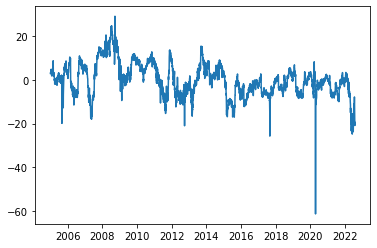

In [211]:
plt.plot(resid)

### ADF test
**ADF test equation**
use ADF test for unit root with lag1:
$$\Delta e_t = \varphi e_{t-1} + \varphi_{aug1}\Delta e_{t-1} + const + \varphi_tt+\epsilon_t$$
- Improvement 1. Test equation above includes time dependence  $\varphi_tt$ , referred to as 'trend'.
I don't include trend in the ADF tests and cointegrating residual -- it will make me think cointegration is present when it is very weak. In fact, without $\varphi_tt$ term, we might not even get stationarity result.

In [212]:
def ADF_test(resid, name):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    '''
    :param resid: dataframe-like, the residual from OLS or any other series to be tested
    '''
    index = resid.index
    resid = np.array(resid).flatten()
    series = pd.DataFrame({'e_t':resid},index = index)
    series['e_t-1'] = series['e_t'].shift(1)
    series['Δe_t'] = series['e_t'].diff()
    series['Δe_t-1'] = series['e_t'].diff().shift(1)
    
    series = series.dropna()
    x = series[['e_t-1','Δe_t-1']]
    y = series['Δe_t']
    
    model = sm.OLS(y, sm.add_constant(x)).fit()

    summary = pd.DataFrame({f"Estimate ΔRes({name})":model.params,
                           f"SD of Estimate ΔRes({name})":model.bse,
                           f"t-Statistic ΔRes({name})":model.tvalues,
                           f"P-value ΔRes({name})":model.pvalues})
    summary = np.around(summary,6)
    display(summary)
    
    print("---------ADF result--------:")
    adf = adfuller(series['e_t'],regression='c',maxlag=1)
    pvalue = round(adf[1],6)
    if pvalue < 0.05:
        print('p-value = ' + str(pvalue) + ' The series ' + name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + name +' is likely non-stationary.')
    
ADF_test(resid, 'NG') 

,Estimate ΔRes(NG),SD of Estimate ΔRes(NG),t-Statistic ΔRes(NG),P-value ΔRes(NG)
const,-0.006266,0.024423,-0.256547,0.79754
e_t-1,-0.018515,0.003276,-5.651178,0.00000
Δe_t-1,-0.214267,0.014729,-14.547178,0.00000


---------ADF result--------:
p-value = 1e-06 The series NG is likely stationary.


In [179]:
resid

,resid
Date,
2017-12-01,-861.587186
2017-12-02,-721.958146
2017-12-03,-504.956320
2017-12-04,-228.147291
2017-12-05,122.350671
...,...
2022-07-26,-3416.620224
2022-07-27,-4281.415418
2022-07-28,-4541.014315


# Source:
[1] https://www.sciencedirect.com/science/article/abs/pii/S1386418114000809